In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import POD, DMD, ROM, DMDc
import matplotlib.pyplot as plt
import scipy.interpolate as si

**Import data**

In [2]:
pist_pressure = np.load("../DATA/Fsi_Results/pist_pressure.npy")
nnt = pist_pressure.shape[0]
fl_pressure = np.load("../DATA/Fsi_Results/fl_pressure.npy")
fl_rho_e = np.load("../DATA/Fsi_Results/fl_rho_e.npy")
fl_rho_v = np.load("../DATA/Fsi_Results/fl_rho_v.npy")
fl_velocity_end = np.load("../DATA/Fsi_Results/fl_velocity_end.npy")
fl_rho = np.load("../DATA/Fsi_Results/fl_rho.npy")
moving_mesh = np.load("../DATA/Fsi_Results/fl_moving_mesh.npy")
delta_t = np.load("../DATA/Fsi_Results/delta_t.npy")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho
sol_accel = np.load("../DATA/Fsi_Results/sol_accel.npy")
Ec = np.load("../DATA/Fsi_Results/Ec.npy")
Em = np.load("../DATA/Fsi_Results/Em.npy")
Ep = np.load("../DATA/Fsi_Results/Ep.npy")
Imp_fl = np.load("../DATA/Fsi_Results/Imp_fl.npy")

t = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]
L = 1
L0 = 1
mass = 1000
rigid = 1e7
Ls0 = 1.2
Lse = Ls0 - 1e5 / rigid


## DMDc Reduction

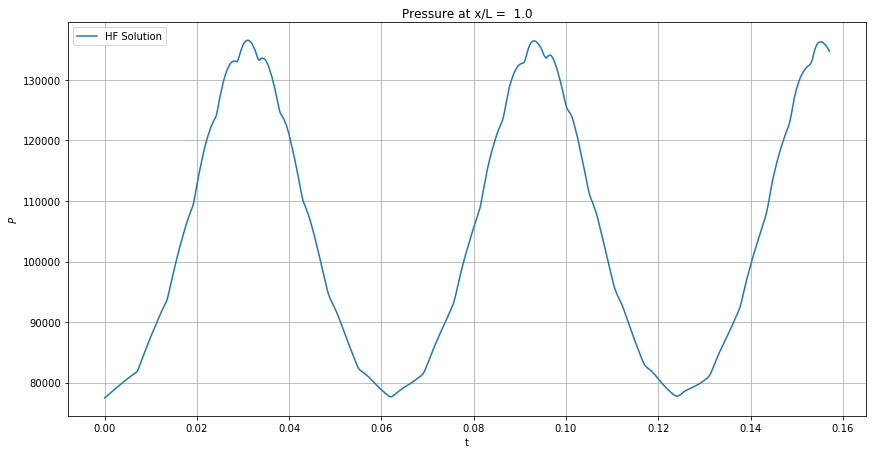

In [3]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1

fig = plt.figure(figsize = (12, 6))

plt.plot(t, fl_pressure[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();
plt.xlabel("t");
plt.ylabel("$P$");
plt.title("Pressure at x/L =  " + str(L * (nx - x_n + 1)/nx));

The HF solution captures 2.5 periods of the system, we will train the ROM on 1.75 periods and 200 points and the rest will be used for testing

**Interpolate to fixed time intervals**

In [4]:
# Choose number of equally spaced timesteps 
n_T = 2.5
n_snap = 280
frac = 1.75
ntt = int(n_snap /(frac/n_T))
dt = (t[-1] - t[0]) / (ntt - 1)

# Interpolating original data to the new timesteps
target_t = np.linspace(t[0], t[-1], ntt)
target_fl_pressure = si.griddata(t, fl_pressure.T, target_t, method='nearest').T
target_fl_velocity = si.griddata(t, fl_velocity.T, target_t, method='nearest').T
target_fl_m_mesh = si.griddata(t, moving_mesh.T, target_t, method='nearest').T
target_sol_accel = si.griddata(t, sol_accel.T, target_t, method='nearest').T

**Probe data for training**

In [5]:
# Choose coefficient of time interval(of data) chosen for training
Coeff = frac/n_T

# Training data (considering moving mesh)
XY_DATA = np.concatenate((target_fl_pressure[:, :int(ntt * Coeff)], target_fl_velocity[:, :int(ntt * Coeff)], 
                          target_fl_m_mesh[:, :int(ntt * Coeff)], target_sol_accel[:int(ntt * Coeff)][np.newaxis, :]))
X = XY_DATA[:, :-1]
Y = XY_DATA[:, 1::]

**DMDc reduction**

In [6]:
#Fixed control inputs:
u_input = np.ones((1, X.shape[1]))

# DMD
rank = 0
dmdc = DMDc()
dromc = ROM(dmdc)
dromc.decompose(X,  Y = Y, dt = dt, rank =rank, Y_input = u_input, opt_trunc=True)

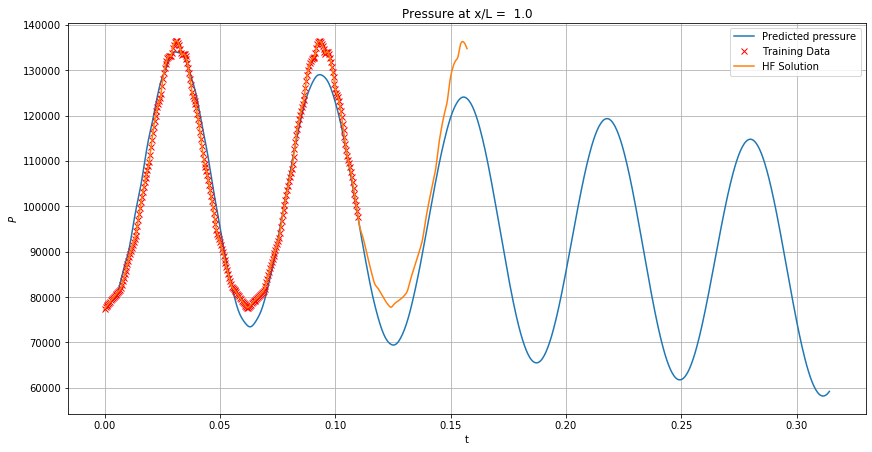

In [7]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1
satbilize_ = False

fig = plt.figure(figsize = (12, 6))
prediction_t = np.concatenate((target_t, target_t + target_t[-1]))


# ------------------------------------------------Affine DMD prediction ----------------------------------
# --------------------------------------------------------------------------------------------------------

# --------- Prediction using the continuous approach ------------------
predicted_X = np.real(dromc.predict(prediction_t, t1 = t[0], stabilize=satbilize_, fixed_input=True, u_input = u_input))

# --------- Prediction using the discrete approach ------------------
#predicted_X = np.real(dromc.predict(prediction_t, t1 = t[0], stabilize=satbilize_, u_input = np.ones((1, prediction_t.shape[0]))))
#prediction_t = np.concatenate((prediction_t, np.array([prediction_t[-1]+dt])))

# --------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------


# Post Processing
predicted_pressure = predicted_X[:nx, :]
predicted_mesh = predicted_X[2 * nx: 3*nx, :]


# Plotting results
plt.plot(prediction_t, predicted_pressure[-x_n, :], '-', label = "Predicted pressure")
plt.plot(target_t[: int(ntt * Coeff)], target_fl_pressure[-x_n, :int(ntt * Coeff)], 'xr', label = "Training Data");
plt.plot(t, fl_pressure[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();
plt.xlabel("t");
plt.ylabel("$P$");
plt.title("Pressure at x/L =  " + str(L * (nx - x_n + 1)/nx));

**Performance Measuring**

We test here the computational efficiency (through CPU time only for now), for the two DMDc predictions approaches discussed in `DMDc on an unstable linear system.ipynb`:
$$\tilde{\pmb{x}}_{k+1} = \tilde{\pmb{A}} \tilde{\pmb{x}}_{k}+ \tilde{\pmb{b}}$$ via 
```python
data[:, 0] = self.u_hat[:, :rank].T @ init
for i in range(u_input.shape[1]):
    data[:, i+1] = self.A_tilde[:rank, :rank] @ data[:,i][:rank] + self.B_tilde[:rank, :] @ u_input[:, i]
    data = self.u_hat[:, :rank] @ data
```


**VS**

$$\pmb{x(t)} = \Phi (e^{\Omega t} \pmb b - \Omega^{-1} \Phi^{\dagger}\hat{\pmb{U}} \tilde{\pmb{B}} u_{input}) $$ via
```python
self.dmd_modes[:, :rank] @ (np.exp(np.outer(eig, t).T) * b[:rank]).T \
                - (self.control_component @ u_input[:, 0])[:, np.newaxis]
```


In [8]:
def subplot(ax, data, title, x_dat, ylabel = None, xlabel=None, sdev = 2, label = None):
    mean = data.mean(axis=0)
    ax.loglog(x_dat, mean, "-o", label = label)
    std = data.std(axis=0)
    ax.fill_between(x_dat, mean - sdev * std, mean + sdev * std, color="k", alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [9]:
# DMD
rank = 0
dmdc = DMDc()
dromc = ROM(dmdc)
dromc.decompose(X,  Y = Y, dt = dt, rank =rank, Y_input = u_input)

t_size = np.linspace(100, 4000, 5, dtype = int)
ranks_ = np.linspace(10, X.shape[1], 5, dtype = int)
n_runs = 15

discrete_delt_t = np.zeros((n_runs, t_size.shape[0]))
discrete_delt_r = np.zeros((n_runs, t_size.shape[0]))
cont_delt_t = np.zeros((n_runs, t_size.shape[0]))
cont_delt_r = np.zeros((n_runs, t_size.shape[0]))

for i in range(n_runs):
    for j in range(t_size.shape[0]):
        
        target_t = np.linspace(t[0], t[-1], t_size[j])
        # --------- Prediction using the continuous approach ------------------
        predicted_X = np.real(dromc.predict(prediction_t, t1 = t[0], fixed_input=True, u_input = u_input))
        cont_delt_t[i, j] = dromc.profile["Prediction time"]

        # --------- Prediction using the discrete approach ------------------
        predicted_X = np.real(dromc.predict(prediction_t, t1 = t[0], u_input = np.ones((1, prediction_t.shape[0]))))
        discrete_delt_t[i, j] = dromc.profile["Prediction time"]

        
for i in range(n_runs):
    for j in range(ranks_.shape[0]):

        prediction_t = np.concatenate((target_t, target_t + target_t[-1]))
        rank = ranks_[j]
        # --------- Prediction using the continuous approach ------------------
        predicted_X = np.real(dromc.predict(prediction_t, t1 = t[0], fixed_input=True, u_input = u_input, rank = rank))
        cont_delt_r[i, j] = dromc.profile["Prediction time"]

        # --------- Prediction using the discrete approach ------------------
        predicted_X = np.real(dromc.predict(prediction_t, t1 = t[0], u_input = np.ones((1, prediction_t.shape[0])), rank = rank))
        discrete_delt_r[i, j] = dromc.profile["Prediction time"]

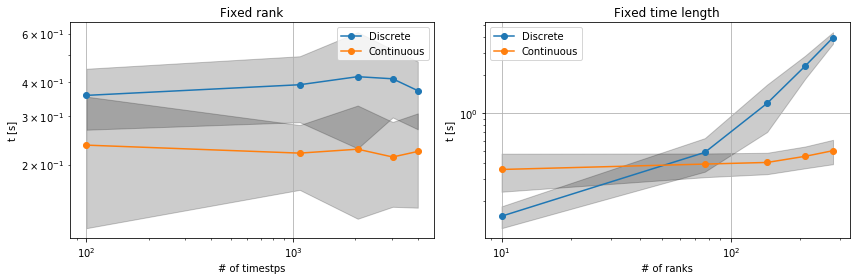

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

subplot(ax[0], discrete_delt_t, "Fixed rank", x_dat = t_size, label = "Discrete")
subplot(ax[0], cont_delt_t, "Fixed rank", x_dat = t_size, ylabel = "t [s]", xlabel = "# of timestps", label="Continuous")
ax[0].grid()
ax[0].legend()

subplot(ax[1], discrete_delt_r, "Fixed time length", x_dat = ranks_, label = "Discrete")
subplot(ax[1], cont_delt_r, "Fixed time length", x_dat = ranks_, ylabel = "t [s]", xlabel = "# of ranks", label="Continuous")
ax[1].grid()
ax[1].legend()

fig.tight_layout();